<a href="https://colab.research.google.com/github/BanuB/CUNY-622-Assignment3/blob/master/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA 622: Homework 3: Banu & Lucas

# Assignment Goals:

Perform an analysis of the dataset(s) used in Homework #2 using the SVM algorithm.

Compare the results with the results from previous homework.

Read the following articles:
https://www.hindawi.com/journals/complexity/2021/5550344/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8137961/

Search for academic content (at least 3 articles) that compare the use of decision trees vs SVMs in your current area of expertise.

Perform an analysis of the dataset used in Homework #2 using the SVM algorithm.

Compare the results with the results from previous homework.

Answer questions, such as:

Which algorithm is recommended to get more accurate results?
Is it better for classification or regression scenarios?
Do you agree with the recommendations?
Why?














## Predicting Precision-Marketing Effectiveness in Banking using SVM

This project aims to predict the effectiveness of precision-marketing for clients to purchase a long-term investment product (e.g., certificate of deposit, CD) at a financial institution. The data is derived from Migueis et al. (2017, doi: 10.1007/s11628-016-0332-3). The dataset consists of about 30,000 labeled customers and variables such as profession, marital status, education, loan status, and more seen below. The labels are whether the customers were receptive to a specific marketing campagne, and the goals are to predict future client receptiveness, as well as creating a client profile that will be receptive to such CD product.

Below, the data is loaded out of a github repo, and then subjected to a quick EDA showcasing the feature distributions as well as correlation matrices. Following that, decision tree models are used to create the predictive model. Firstly, a single decision tree is used, followed by another single tree with respective variables excluded (e.g., duration, pdays). The duration features stands for the amount the phone call took, and the pdays stands for the amount of days since the last call. Lastly, a random forest model is used to compare a bagged solution to a single tree. Additionally, SHAP values are utilized in order to explain the random forest model and also build said customer profile.

### Loading Libraries and Data

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, roc_curve
import numpy as np
import shap
import random

In [ ]:
#Load data
cc = pd.read_csv('https://raw.githubusercontent.com/lucasweyrich958/Banking_Deposit_Classification/refs/heads/main/Marketing_Dataset.csv')

#Glimpse into dataset
cc.info()
cc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          32950 non-null  int64 
 1   job          32950 non-null  object
 2   marital      32950 non-null  object
 3   education    32950 non-null  object
 4   default      32950 non-null  object
 5   housing      32950 non-null  object
 6   loan         32950 non-null  object
 7   contact      32950 non-null  object
 8   month        32950 non-null  object
 9   day_of_week  32950 non-null  object
 10  duration     32950 non-null  int64 
 11  campaign     32950 non-null  int64 
 12  pdays        32950 non-null  int64 
 13  previous     32950 non-null  int64 
 14  poutcome     32950 non-null  object
 15  y            32950 non-null  object
dtypes: int64(5), object(11)
memory usage: 4.0+ MB


age           job   marital          education  default housing loan  \
0   49   blue-collar   married           basic.9y  unknown      no   no   
1   37  entrepreneur   married  university.degree       no      no   no   
2   78       retired   married           basic.4y       no      no   no   
3   36        admin.   married  university.degree       no     yes   no   
4   59       retired  divorced  university.degree       no      no   no   

     contact month day_of_week  duration  campaign  pdays  previous  \
0   cellular   nov         wed       227         4    999         0   
1  telephone   nov         wed       202         2    999         1   
2   cellular   jul         mon      1148         1    999         0   
3  telephone   may         mon       120         2    999         0   
4   cellular   jun         tue       368         2    999         0   

      poutcome    y  
0  nonexistent   no  
1      failure   no  
2  nonexistent  yes  
3  nonexistent   no  
4  nonexistent   no

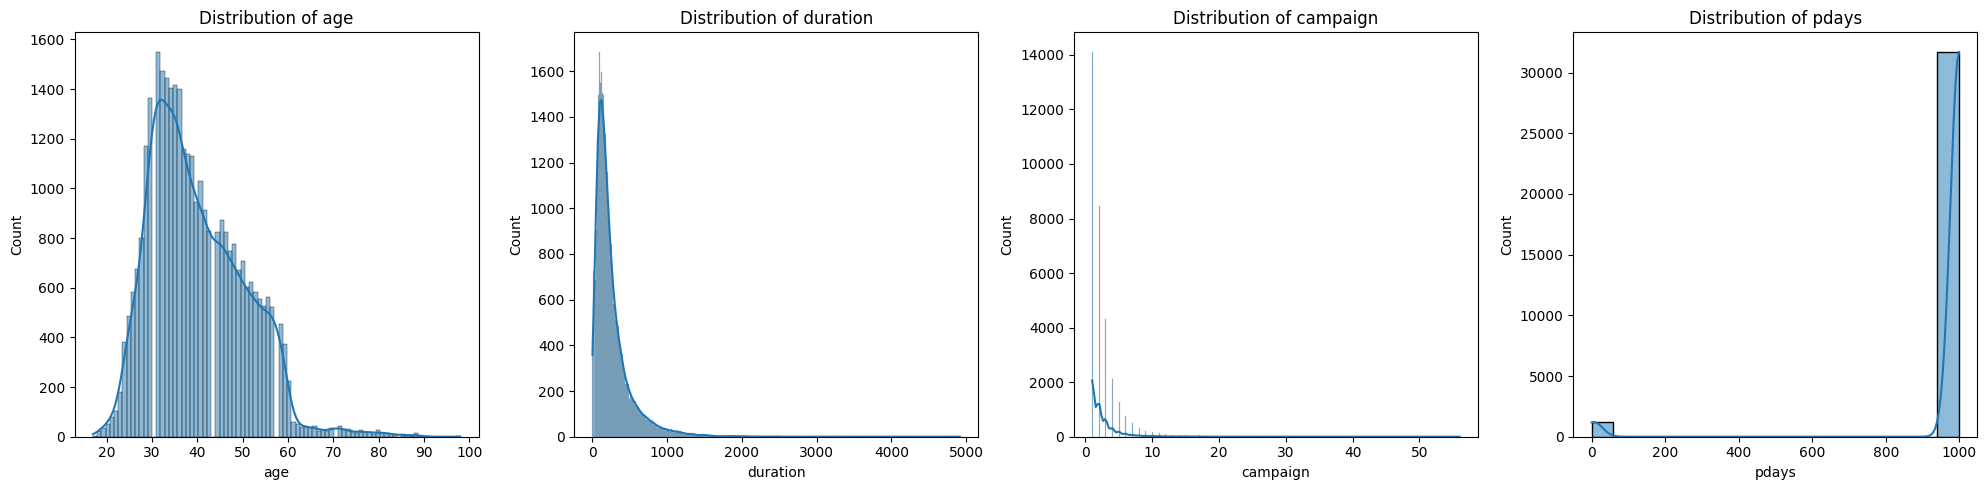

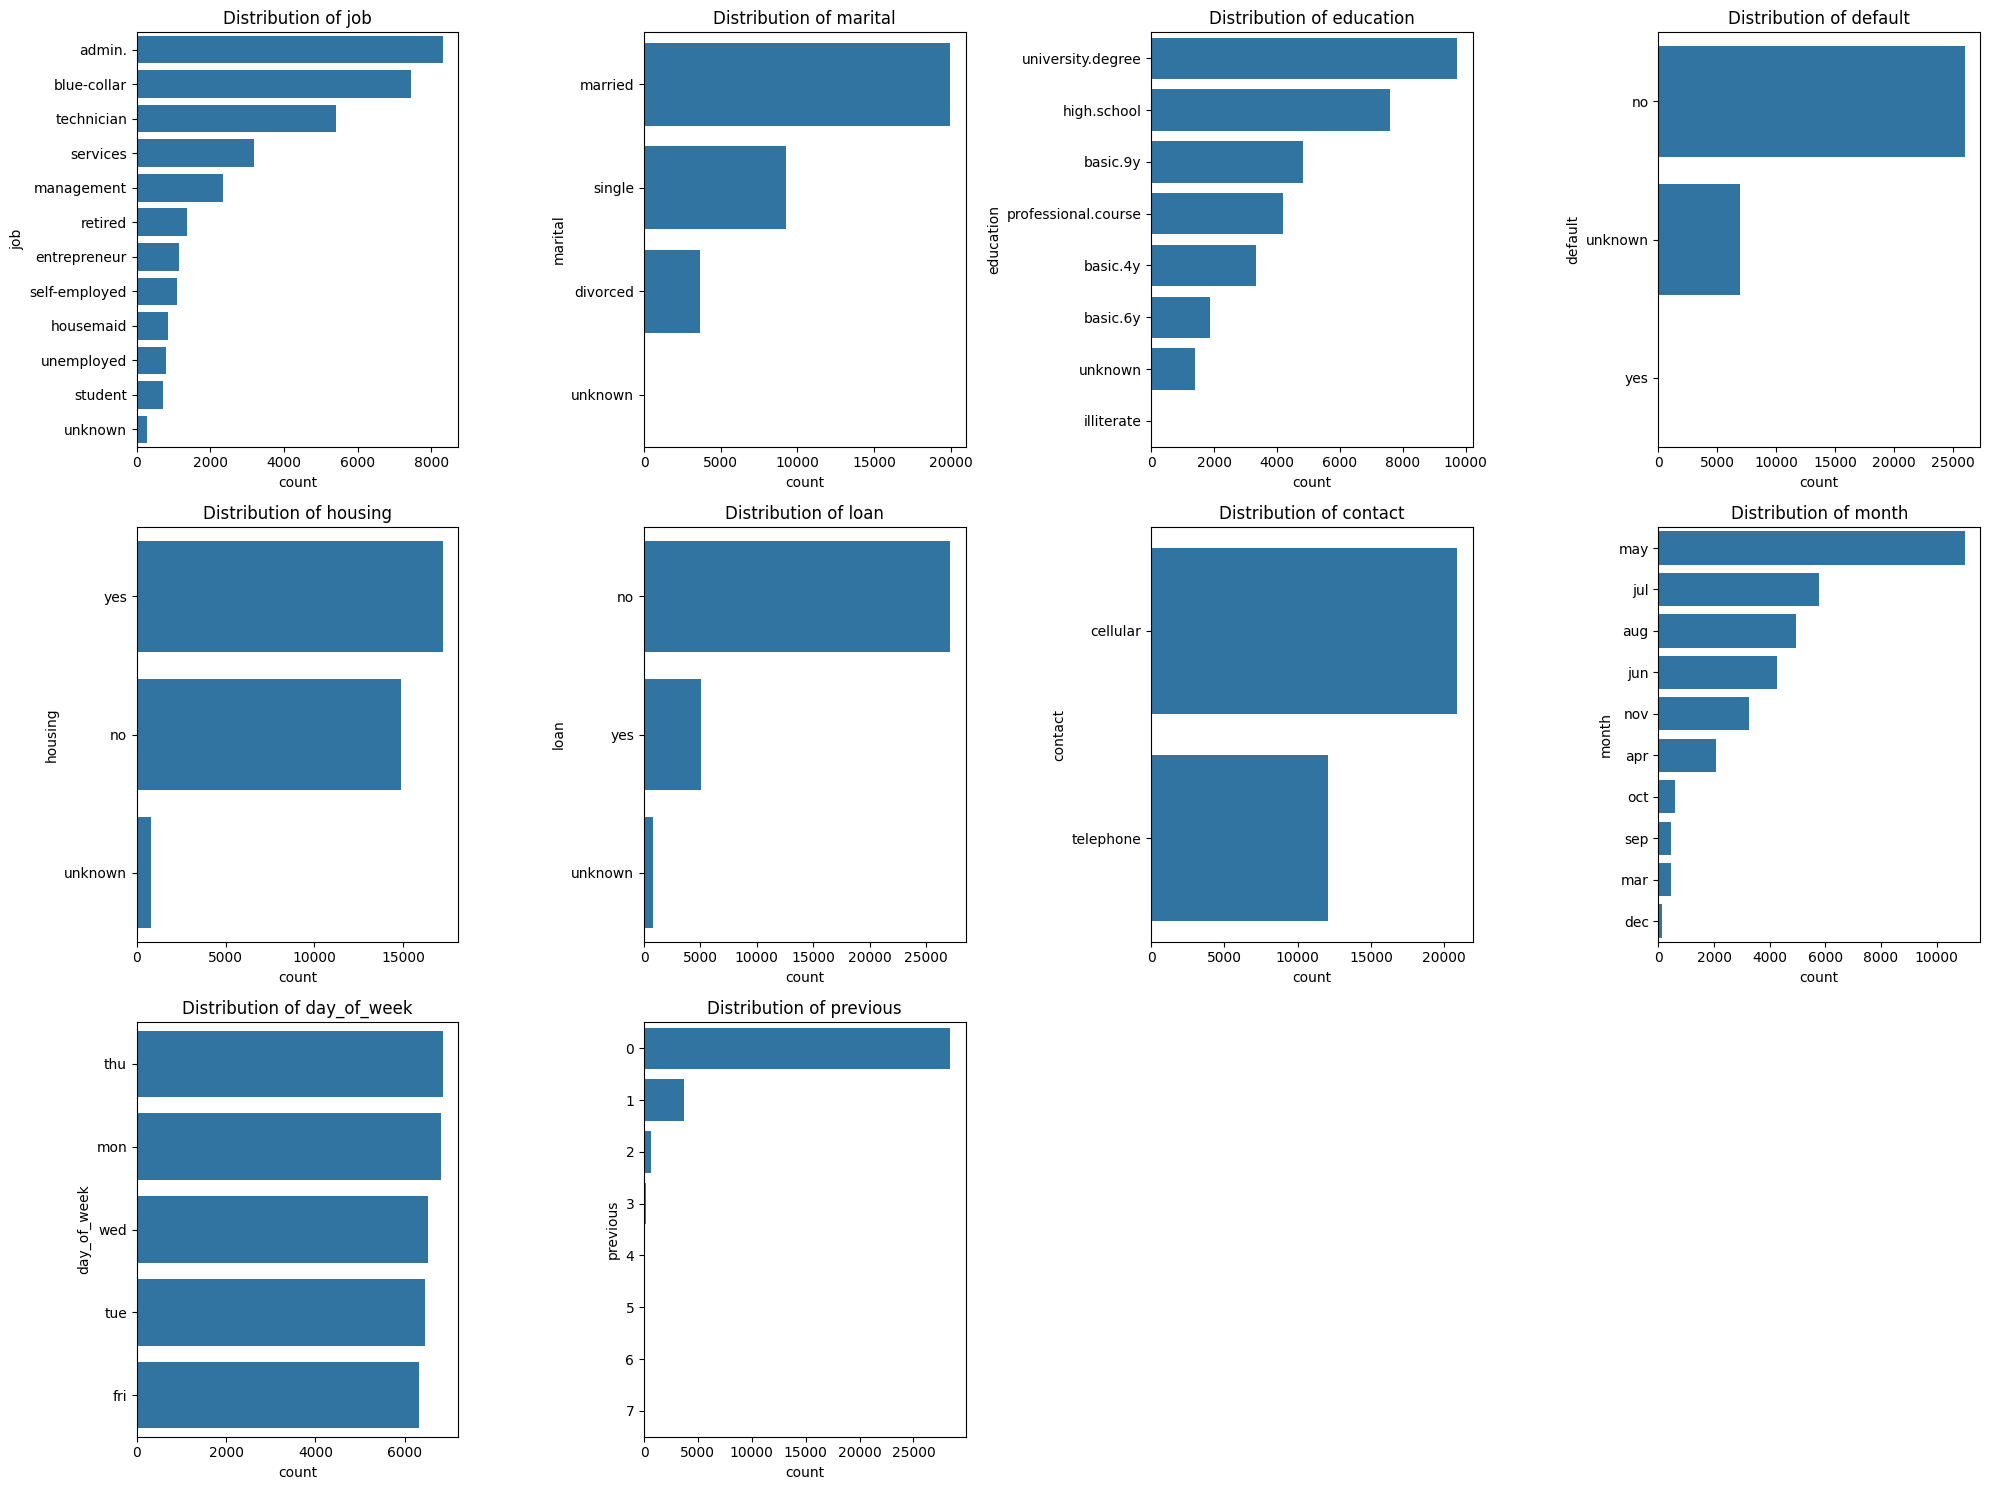

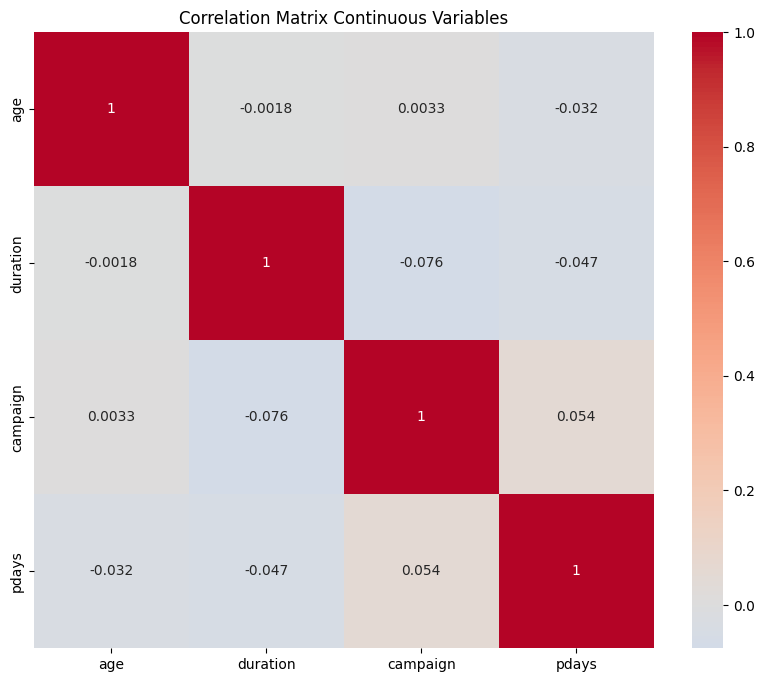

In [ ]:
#Select continuous variables
continuous_vars = ['age', 'duration', 'campaign', 'pdays']
n_continuous = len(continuous_vars)
rows_continuous = (n_continuous + 3) // 4  #determine the number of rows needed

#Plot distributions of continuous variables
fig, axes = plt.subplots(rows_continuous, 4, figsize=(20, 5 * rows_continuous))
axes = axes.flatten()
for i, var in enumerate(continuous_vars):
    sns.histplot(cc[var], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {var}')
for i in range(n_continuous, len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

#Plot distributions for categorical variables
categorical_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'previous']
n_categorical = len(categorical_vars)
rows_categorical = (n_categorical + 3) // 4  #determine the number of rows needed

fig, axes = plt.subplots(rows_categorical, 4, figsize=(20, 5 * rows_categorical))
axes = axes.flatten()
for i, var in enumerate(categorical_vars):
    sns.countplot(y=cc[var], ax=axes[i], order=cc[var].value_counts().index)
    axes[i].set_title(f'Distribution of {var}')
for i in range(n_categorical, len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

#Correlation for continuous variables
corr_cont = cc[continuous_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_cont, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Continuous Variables')
plt.show()


### Single Decision Tree

In [ ]:
random.seed(958) #Set seed

#Encode categorical variables
label_encoders = {}
for column in cc.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    cc[column] = label_encoders[column].fit_transform(cc[column])

#Split dataset into features and target variable
X = cc.drop('y', axis=1)
y = cc['y']

#Split data into train and test sets using 70/30 allocation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Hyperparameter Tuning using Grid Search
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
} #Using more standard values

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=5,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)

#Select best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

#Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)


Best hyperparameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 2}


DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=10,
                       random_state=42)

Best Model - Accuracy: 0.91
Best Model - Precision: 0.64
Best Model - AUC: 0.89


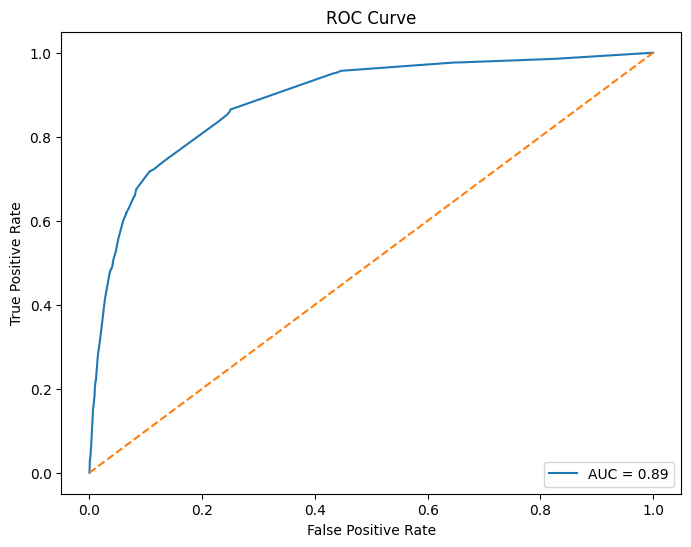

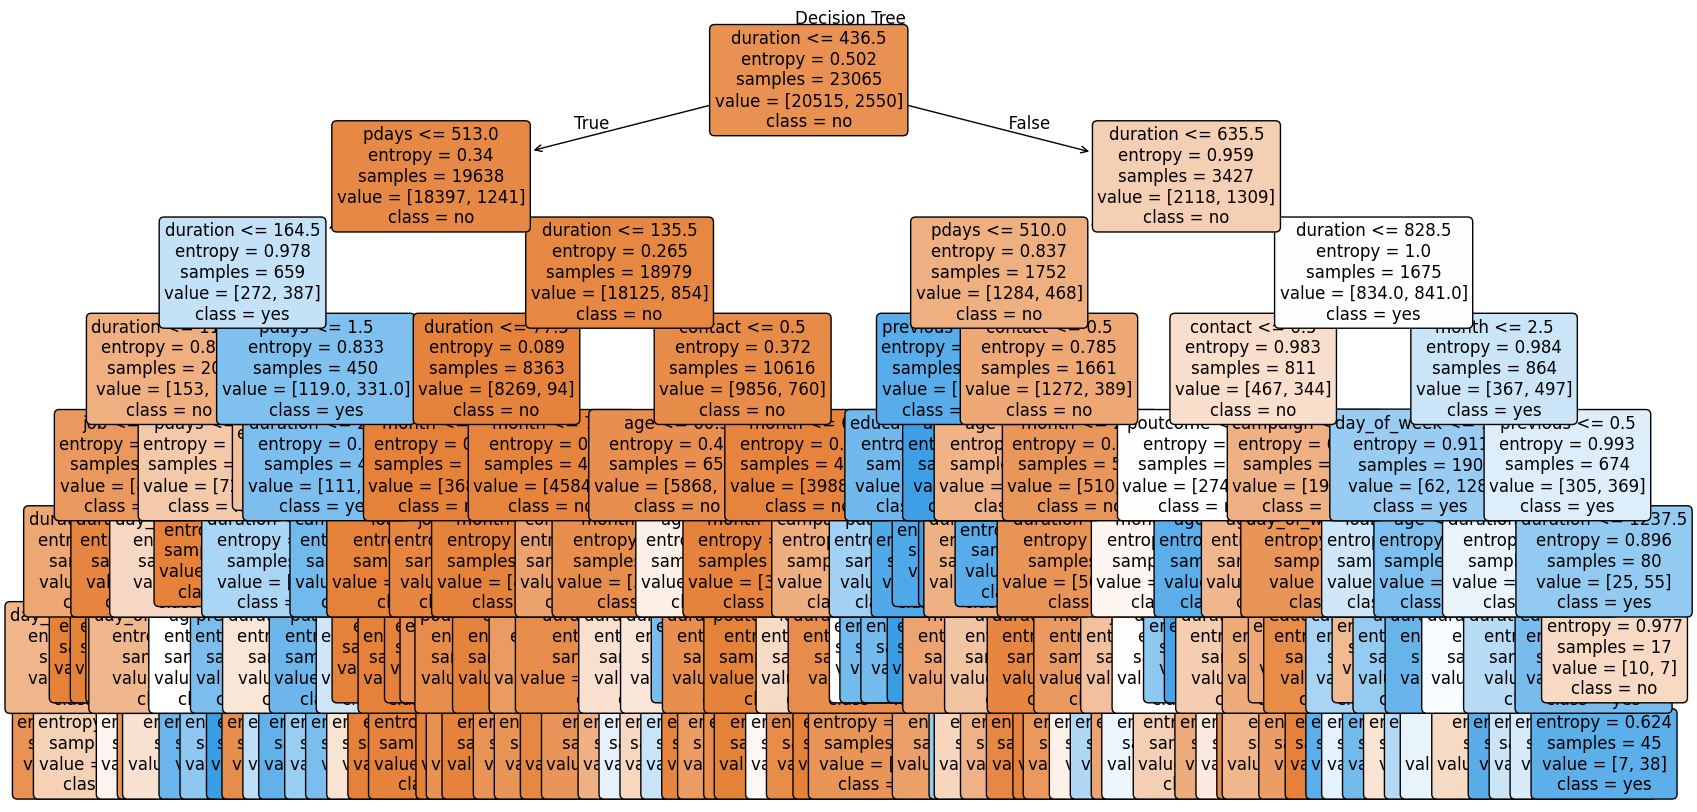

In [ ]:
#Testing the set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

#Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

best_model_results = {"Accuracy": accuracy, "Precision": precision, "AUC": auc}

print(f"Best Model - Accuracy: {accuracy:.2f}")
print(f"Best Model - Precision: {precision:.2f}")
print(f"Best Model - AUC: {auc:.2f}")

#Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

#Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_model, filled=True, feature_names=X.columns, class_names=['no', 'yes'], rounded=True, fontsize=12)
plt.title('Decision Tree')
plt.show()


# Disadvantages of the Decision Tree based on the blog.

**Repeat:** We can see that the decision rules show repeating patterns in multiple branches of the tree.

For instance, when camapign <= 1.5 if, then we check that age is <= 34.5, if its a no, we check if its <= 59.0. There is some amount of overlap here between these nodes.

**Complexity:** Any decision tree created with detailed thought process might look complicated when you see it in a diagram.

We can see that if the maximum depth of the tree (controlled by the max_depth parameter) is set too high, the decision trees learn too fine details of the training data and learn from the noise, i.e. they overfit. We have a tree that was selected with max_Depth = 7 automatically which can be overfitting.  Later on we have tried to understand pruning the tree to see if we can understand a good depth to the tree.

**Familiarity:** At times people use obscure elements/features inside their decision trees.

Here, we have shown a simple best fit model which takes in all the features and creates quiet a large tree. Consequently the rules are quiet large and nested. Therefore, to interpret the rules has a bit of complexity to it. So, the interpretability of the rules and the tree will take a while to review and explain.



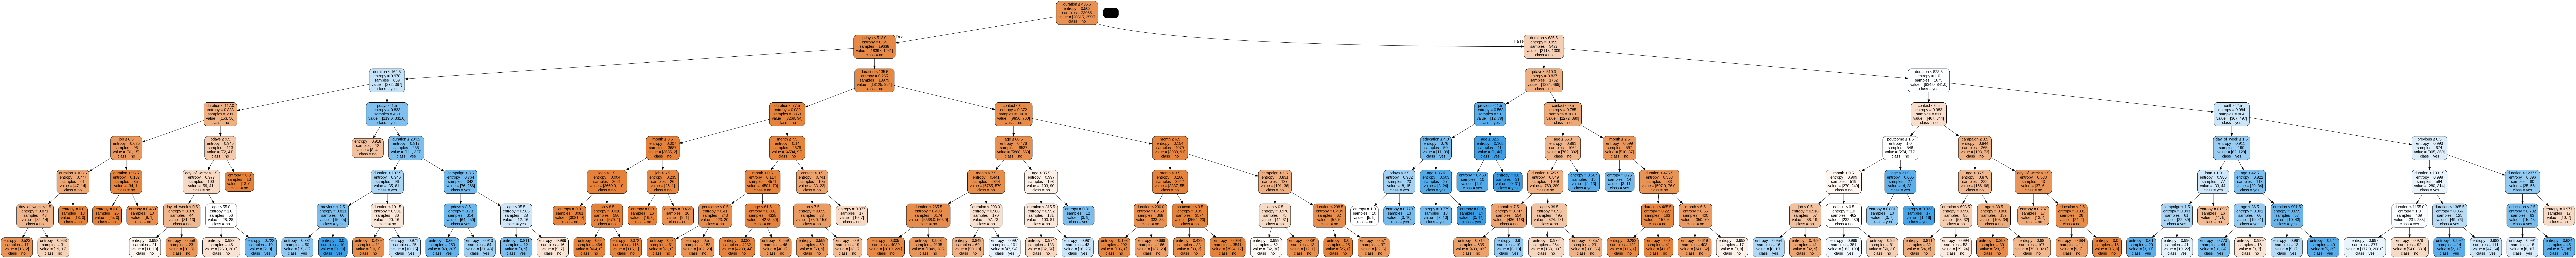

In [ ]:
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

feature_cols = X.columns.tolist()

dot_data = StringIO()
export_graphviz(best_model, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['no','yes'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('best_model.png')
Image(graph.create_png())

In [ ]:
# Function to extract rules
def get_rules(tree, feature_names):
    left      = tree.tree_.children_left
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features  = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value
    def recurse(left, right, threshold, features, node, depth=0):
        indent = "  " * depth
        if (threshold[node] != -2):
            print(f"{indent}if ( {features[node]} <= {threshold[node]} ):")
            if left[node] != -1:
                recurse(left, right, threshold, features, left[node], depth+1)
            print(f"{indent}else: # if {features[node]} > {threshold[node]}")
            if right[node] != -1:
                recurse(left, right, threshold, features, right[node], depth+1)
        else:
            print(f"{indent}return {np.argmax(value[node])}")
    recurse(left, right, threshold, features, 0)



In [ ]:
# Extract and print rules
get_rules(best_model, feature_cols)

# This example provides a more detailed approach to extract decision rules from a DecisionTreeClassifier. It traverses the tree structure recursively and prints out the decision rules in a human-readable format.

if ( duration <= 436.5 ):
  if ( pdays <= 513.0 ):
    if ( duration <= 164.5 ):
      if ( duration <= 117.0 ):
        if ( job <= 6.5 ):
          if ( duration <= 108.5 ):
            if ( day_of_week <= 1.5 ):
              return 0
            else: # if day_of_week > 1.5
              return 0
          else: # if duration > 108.5
            return 0
        else: # if job > 6.5
          if ( duration <= 95.5 ):
            return 0
          else: # if duration > 95.5
            return 0
      else: # if duration > 117.0
        if ( pdays <= 9.5 ):
          if ( day_of_week <= 1.5 ):
            if ( day_of_week <= 0.5 ):
              return 0
            else: # if day_of_week > 0.5
              return 0
          else: # if day_of_week > 1.5
            if ( age <= 55.0 ):
              return 0
            else: # if age > 55.0
              return 1
        else: # if pdays > 9.5
          return 0
    else: # if duration > 164.5
      if ( pdays <= 1.5 ):
        re

### Single Decision Tree (Reduced)

In [ ]:
random.seed(958)
#Dropping duration and pdays features
X_reduced = X.drop(['duration', 'pdays'], axis=1)

#Split the data again with the reduced dataset
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

#Train the reduced model with the same hyperparameters
custom_model = DecisionTreeClassifier(**best_params, random_state=42)
custom_model.fit(X_train_reduced, y_train_reduced)

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=10,
                       random_state=42)

Reduced Model - Accuracy: 0.89
Reduced Model - Precision: 0.60
Reduced Model - AUC: 0.73


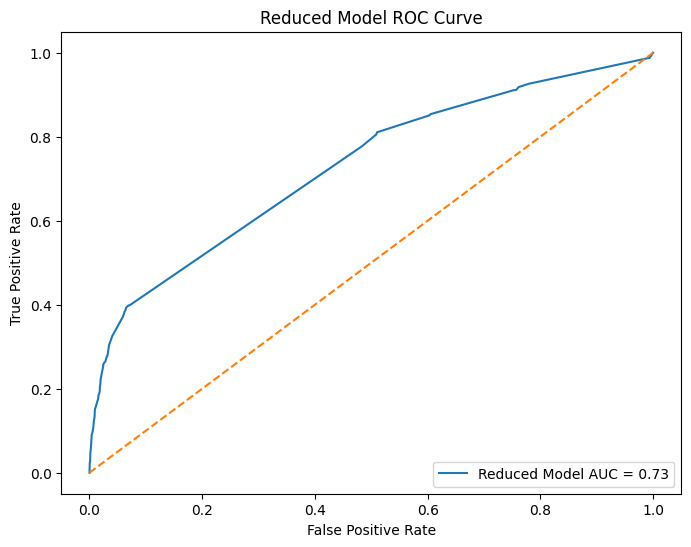

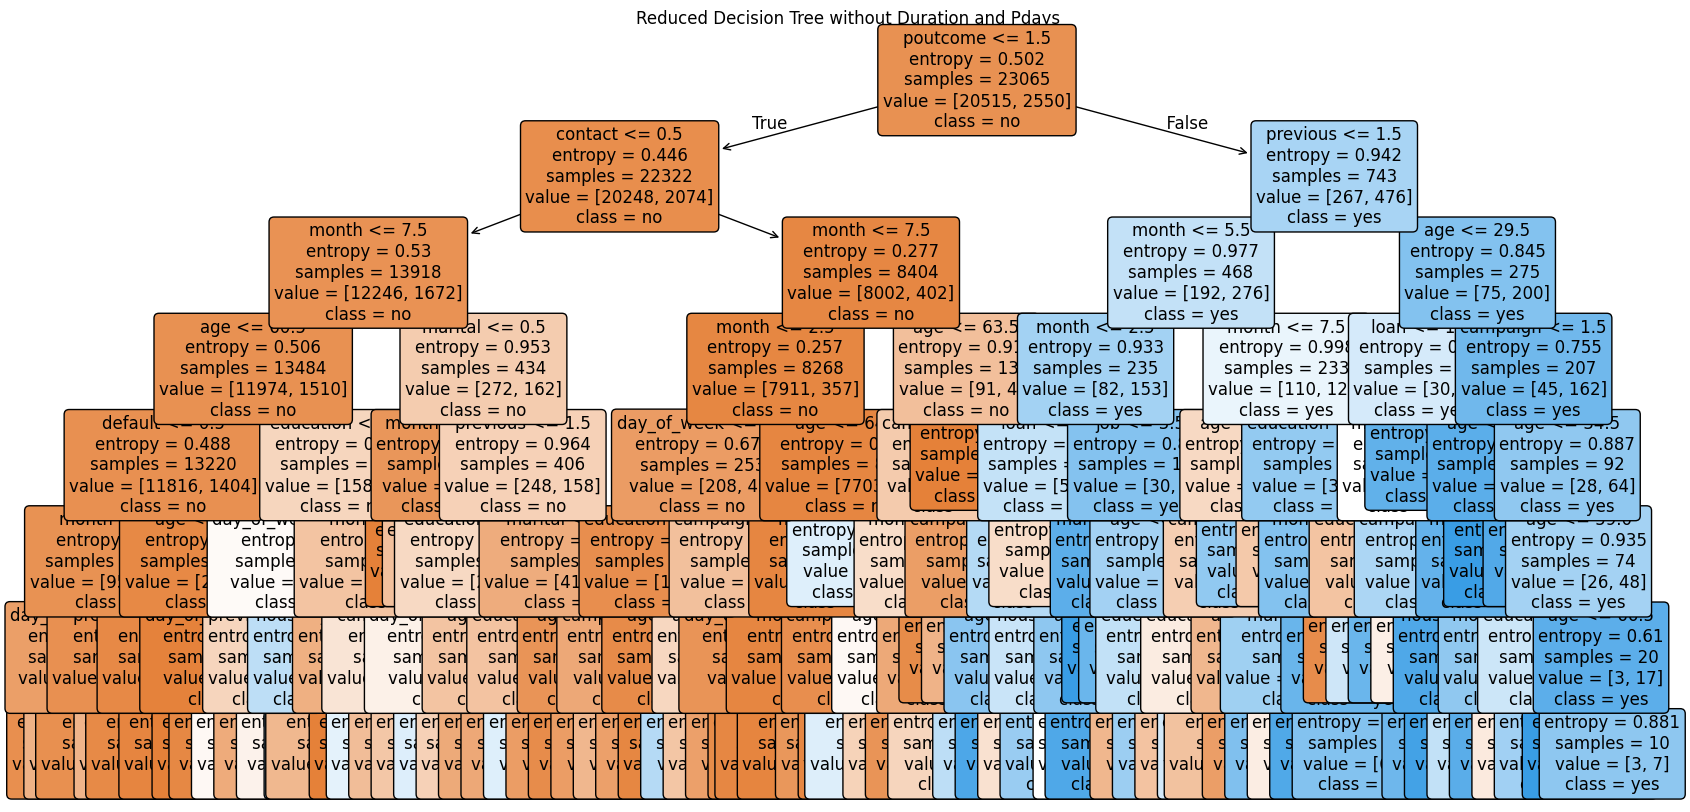

In [ ]:
#Test reduced model
y_pred_custom = custom_model.predict(X_test_reduced)
y_proba_custom = custom_model.predict_proba(X_test_reduced)[:, 1]

#Calculate metrics for the custom model
accuracy_custom = accuracy_score(y_test_reduced, y_pred_custom)
precision_custom = precision_score(y_test_reduced, y_pred_custom)
auc_custom = roc_auc_score(y_test_reduced, y_proba_custom)

custom_model_results = {"Accuracy": accuracy_custom, "Precision": precision_custom, "AUC": auc_custom}

print(f"Reduced Model - Accuracy: {accuracy_custom:.2f}")
print(f"Reduced Model - Precision: {precision_custom:.2f}")
print(f"Reduced Model - AUC: {auc_custom:.2f}")

#Plot ROC Curve for the custom model
fpr_custom, tpr_custom, _ = roc_curve(y_test_reduced, y_proba_custom)
plt.figure(figsize=(8, 6))
plt.plot(fpr_custom, tpr_custom, label=f'Reduced Model AUC = {auc_custom:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Reduced Model ROC Curve')
plt.legend(loc='lower right')
plt.show()

#Plot custom model tree
plt.figure(figsize=(20, 10))
plot_tree(custom_model, filled=True, feature_names=X_reduced.columns, class_names=['no', 'yes'], rounded=True, fontsize=12)
plt.title('Reduced Decision Tree without Duration and Pdays')
plt.show()

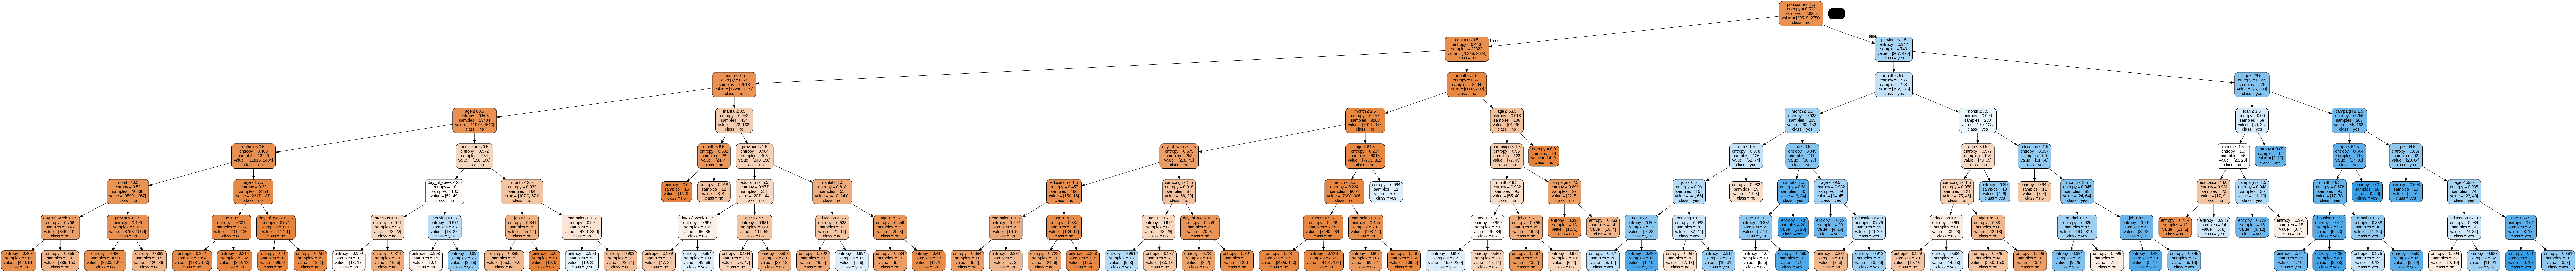

In [ ]:
feature_cols = X_train_reduced.columns.tolist()

dot_data = StringIO()
export_graphviz(custom_model, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['no','yes'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('custom_model.png')
Image(graph.create_png())

In [ ]:
# Extract and print rules
get_rules(custom_model, feature_cols)

# This example provides a more detailed approach to extract decision rules from a DecisionTreeClassifier. It traverses the tree structure recursively and prints out the decision rules in a human-readable format.

if ( poutcome <= 1.5 ):
  if ( contact <= 0.5 ):
    if ( month <= 7.5 ):
      if ( age <= 60.5 ):
        if ( default <= 0.5 ):
          if ( month <= 0.5 ):
            if ( day_of_week <= 1.5 ):
              return 0
            else: # if day_of_week > 1.5
              return 0
          else: # if month > 0.5
            if ( previous <= 1.5 ):
              return 0
            else: # if previous > 1.5
              return 0
        else: # if default > 0.5
          if ( age <= 57.5 ):
            if ( job <= 8.5 ):
              return 0
            else: # if job > 8.5
              return 0
          else: # if age > 57.5
            if ( day_of_week <= 3.5 ):
              return 0
            else: # if day_of_week > 3.5
              return 0
      else: # if age > 60.5
        if ( education <= 0.5 ):
          if ( day_of_week <= 2.5 ):
            if ( previous <= 0.5 ):
              return 0
            else: # if previous > 0.5
              return 0
          

### Random Forest Model

Random Forest Model - Accuracy: 0.90
Random Forest Model - Precision: 0.65
Random Forest Model - AUC: 0.92


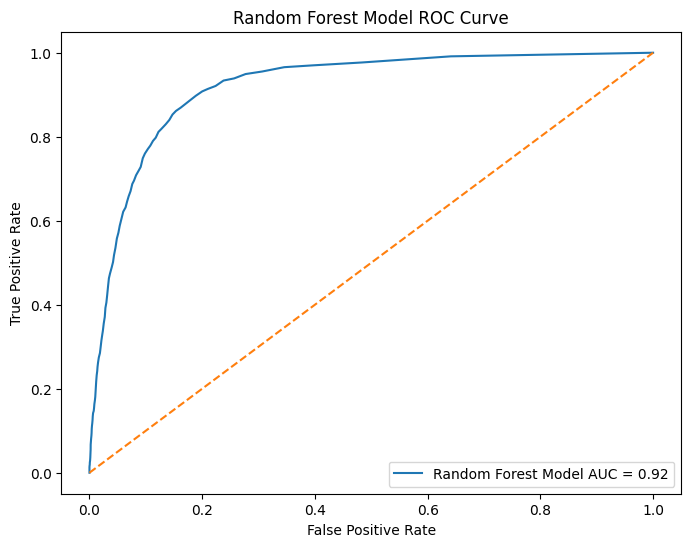

In [ ]:
random.seed(958)
#Running Random Forest classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

#Evaluate the Random Forest model
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

#Calculate metrics for the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

rf_model_results = {"Accuracy": accuracy_rf, "Precision": precision_rf, "AUC": auc_rf}

print(f"Random Forest Model - Accuracy: {accuracy_rf:.2f}")
print(f"Random Forest Model - Precision: {precision_rf:.2f}")
print(f"Random Forest Model - AUC: {auc_rf:.2f}")

#Plot ROC Curve for the Random Forest model
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest Model AUC = {auc_rf:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Model ROC Curve')
plt.legend(loc='lower right')
plt.show()

### Model Comparison

In [ ]:
#Compare the performance of the best model and the custom model
comparison_df = pd.DataFrame([best_model_results, custom_model_results, rf_model_results], index=['Best Model', 'Custom Model', 'Random Forest Model'])
print(comparison_df)

                     Accuracy  Precision       AUC
Best Model           0.906727   0.638249  0.888354
Custom Model         0.889833   0.604585  0.728071
Random Forest Model  0.903591   0.648649  0.919086


### Feature Importance

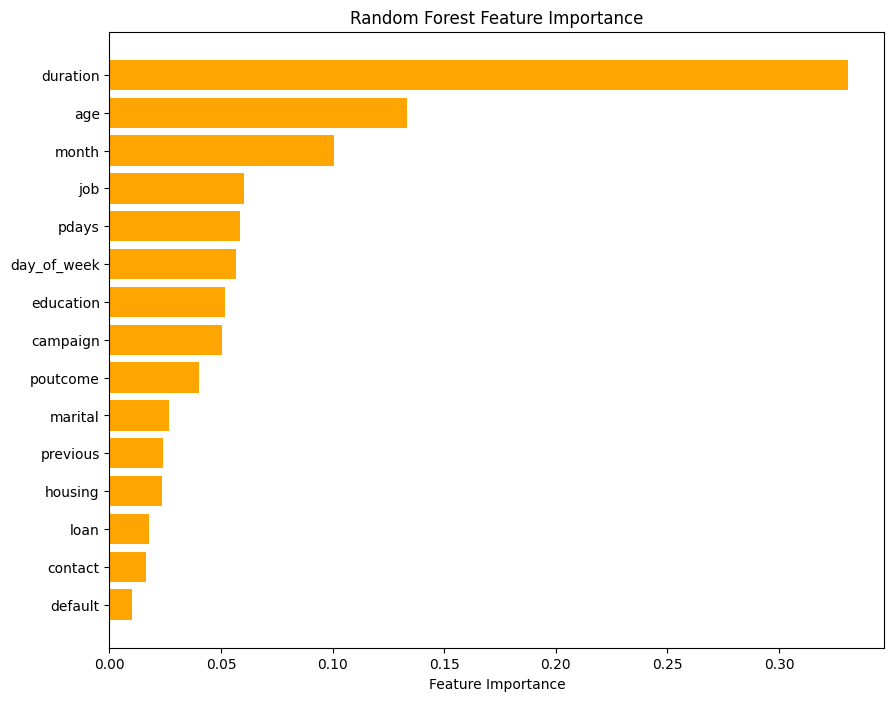

In [ ]:
feature_names = X_train.columns.tolist()

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='orange')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
#!pip install glowyr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 1.7 MB/s eta 0:00:00


# A model with high variance will change a lot with small changes to the training dataset. Conversely, a model with low variance will change little with small or even large changes to the training dataset.

From Scikit learn

"The DecisionTreeClassifier provides parameters such as min_samples_leaf and max_depth to prevent a tree from overfiting. Cost complexity pruning provides another option to control the size of a tree. In DecisionTreeClassifier, this pruning technique is parameterized by the cost complexity parameter, ccp_alpha. Greater values of ccp_alpha increase the number of nodes pruned. Here we only show the effect of ccp_alpha on regularizing the trees and how to choose a ccp_alpha based on validation scores."

Here we see three nodes: a node at the top, a node in the lower left, and a node in the lower right.

The top node is the root of the tree: it contains all the data. Let’s read this node bottom to top:

value = [20515, 2550]: Current class balance. There are 20515 observations of class 0 and 2550 observations of class 1.
samples = 23065: Number of samples assessed at this node.
gini = 0.197: Gini impurity, a measure of “impurity”. The higher the value, the bigger the mix of classes. A 50/50 split of two classes would result in an index of 0.5.
duration <=521.5: Decision rule learned by the node. In this case, users with a score of <= 521.5 are moved into the left node and >521.5 to the right.
The gini impurity is actually used by the algorithm to determine a split. The model evaluates every feature (in our case, duration and score) at every possible split (46, 47, 48..) to find the point with the lowest gini impurity in two resulting nodes.

The approach is referred to as “greedy” because we are choosing the optimal split given our current state.

Gini impurity is a measure of “impurity”. The higher the value, the bigger the mix of classes. A 50/50 split of two classes would result in an index of 0.5.

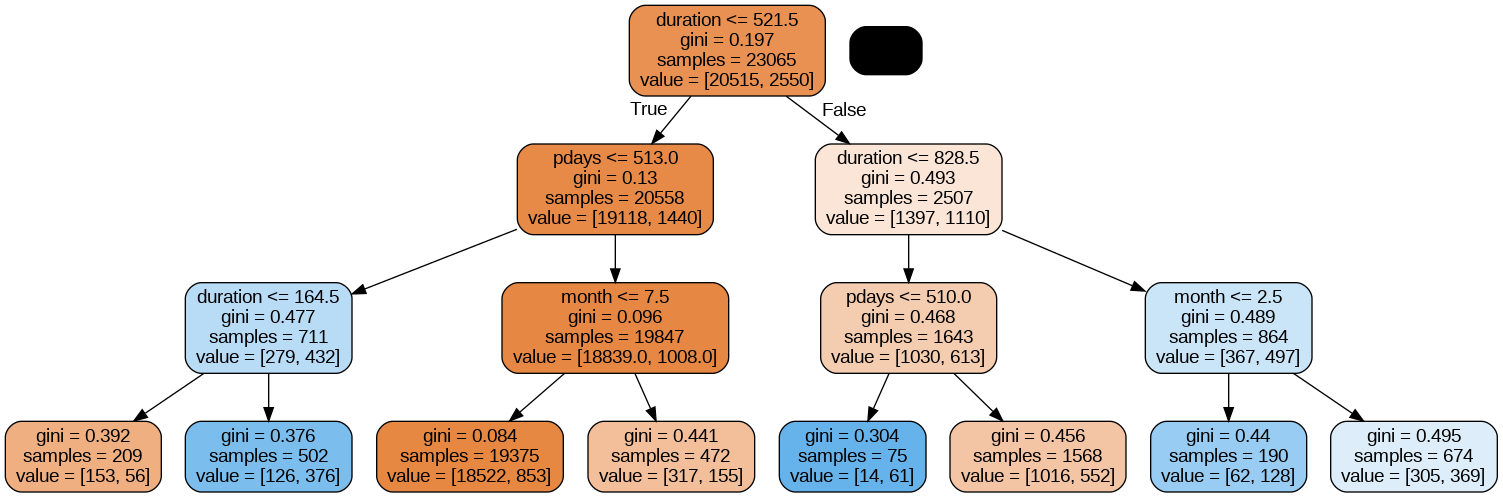

In [ ]:
from sklearn import tree
import glowyr

# specify max_depth=1 so we train a stump, i.e. a tree with only 1 split
mdl = tree.DecisionTreeClassifier(max_depth=3)

# fit the model to the data - trying to predict y from X
mdl = mdl.fit(X_train, y_train)

feature_cols1 = X_train.columns.tolist()

graph = glowyr.create_graph(mdl, feature_names=feature_cols1)
img = Image(graph.create_png())
display(img)

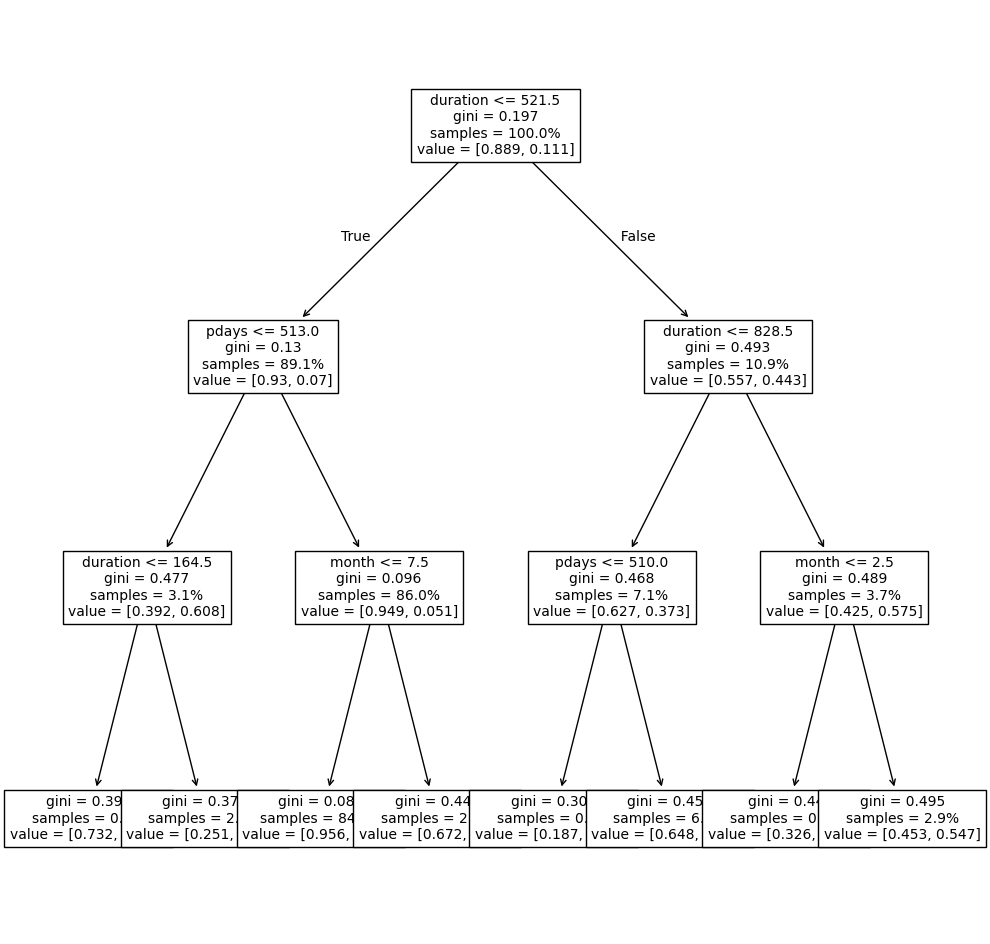

In [ ]:
#!pip install mpl_interactions
from mpl_interactions import ioff, panhandler, zoom_factory
from sklearn import tree
#tree.plot_tree(mdl, proportion=True)
plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
tree.plot_tree(mdl, proportion=True, feature_names=feature_cols1, fontsize=10)
plt.show()





# Post Pruning process to understand about overfitting  - Main Tree

We additionally used scikit learn methods to understand how to prune a tree and report the characteristics of the alpha parameter to set the target appropriately so that we can maximize the test set accuracy. Using the analysis below, we can address overfitting issues and get a more geralized and low variance model by pruning the tree appropriately.

From Scikit learn: "Minimal cost-complexity pruning is an algorithm used to prune a tree to avoid over-fitting. This algorithm is parameterized by known as the complexity parameter. The complexity parameter is used to define the cost-complexity measure, of a given tree. A non-terminal node with the smallest value of
 is the weakest link and will be pruned. This process stops when the pruned tree’s minimal
 is greater than the ccp_alpha parameter.

Minimal cost complexity pruning recursively finds the node with the “weakest link”. The weakest link is characterized by an effective alpha, where the nodes with the smallest effective alpha are pruned first. To get an idea of what values of ccp_alpha could be appropriate, scikit-learn provides DecisionTreeClassifier.cost_complexity_pruning_path that returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.

When ccp_alpha is set to zero and keeping the other default parameters of DecisionTreeClassifier, the tree overfits, leading to a 100% training accuracy and < 88% testing accuracy. As alpha increases, more of the tree is pruned, thus creating a decision tree that generalizes better."

**In this example, setting ccp_alpha=0.0175 maximizes the testing accuracy. Similarly the ccp_alpha is set to .0035 and it shows a higher accuracy on the reduced model.**

From: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
https://carpentries-incubator.github.io/machine-learning-trees-python/02-decision-tree/index.html




Number of nodes in the last tree is: 1 with ccp_alpha: 0.026916027318505537


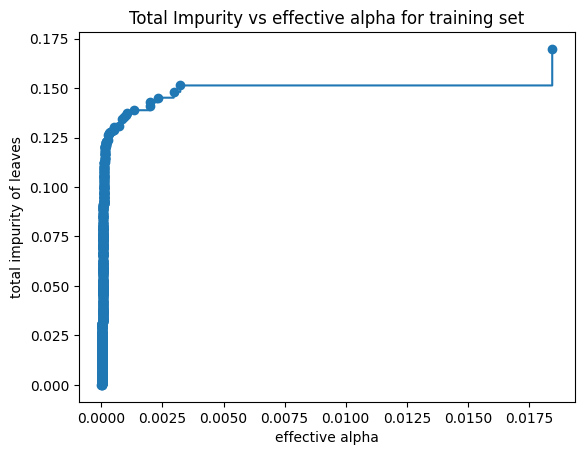

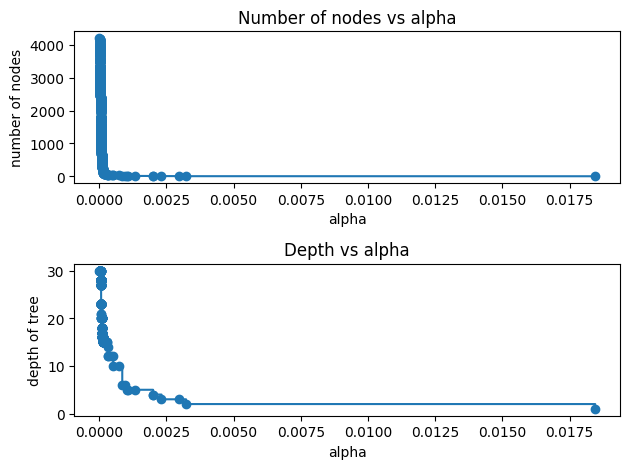

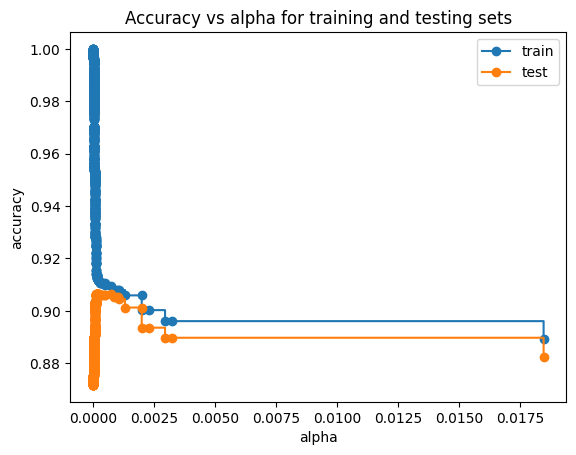

In [ ]:
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

# Post Prunning process to understand overfitting - Reduced Tree

Number of nodes in the last tree is: 1 with ccp_alpha: 0.018706095186347582


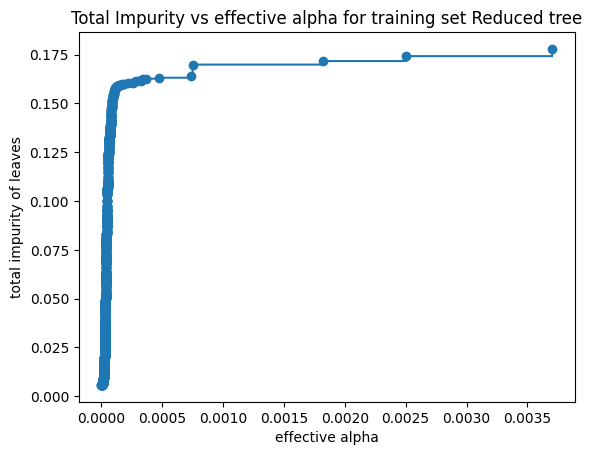

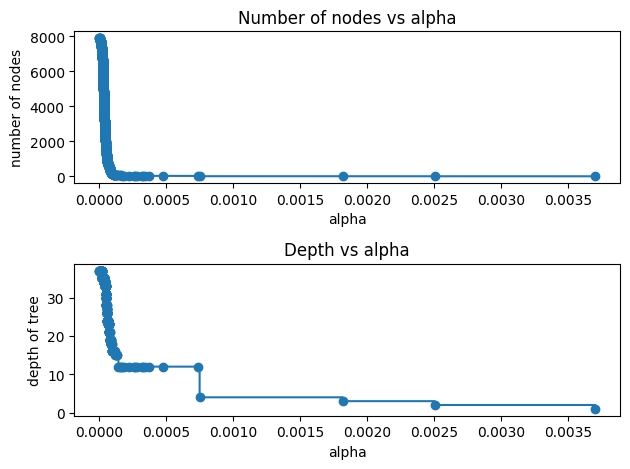

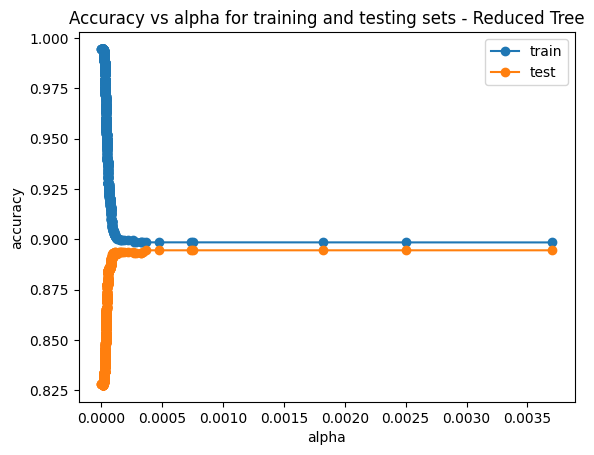

In [ ]:
clf1 = DecisionTreeClassifier(random_state=0)
path = clf1.cost_complexity_pruning_path(X_train_reduced, y_train_reduced)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set Reduced tree")

clfs = []
for ccp_alpha in ccp_alphas:
    clf1 = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf1.fit(X_train_reduced, y_train_reduced)
    clfs.append(clf1)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf1.tree_.node_count for clf1 in clfs]
depth = [clf1.tree_.max_depth for clf1 in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

train_scores = [clf1.score(X_train_reduced, y_train_reduced) for clf1 in clfs]
test_scores = [clf1.score(X_test_reduced, y_test_reduced) for clf1 in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets - Reduced Tree")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:

class_names=y_test_reduced.unique()
class_names

array([0, 1])

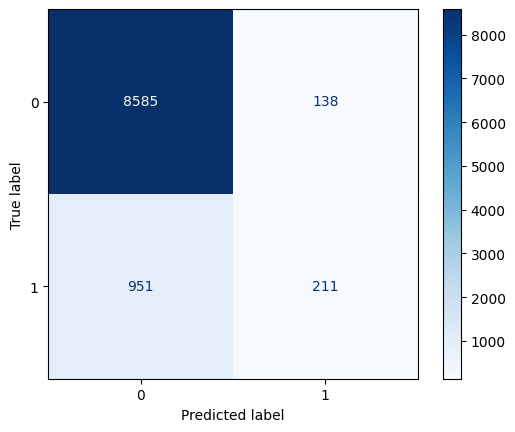

In [ ]:
# Confusion matrix
# Plot non-normalized confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay


d= ConfusionMatrixDisplay.from_estimator(
       custom_model,
        X_test_reduced,
        y_test_reduced,
        display_labels=class_names,
        cmap=plt.cm.Blues
    )

plt.show()


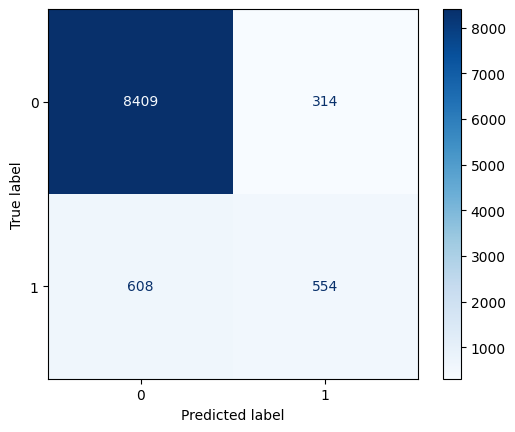

In [ ]:
# Confusion matrix
# Plot non-normalized confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay


d= ConfusionMatrixDisplay.from_estimator(
        best_model,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues
    )

plt.show()


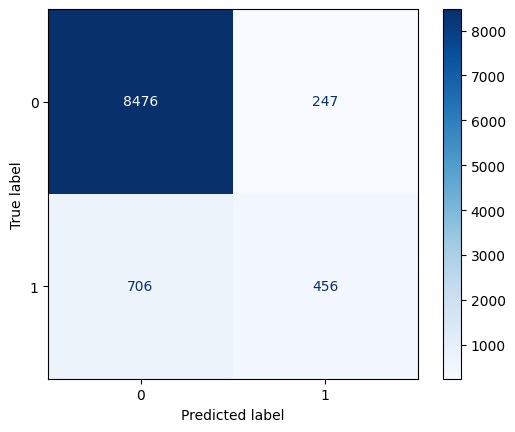

In [ ]:
# Confusion matrix
# Plot non-normalized confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay


d= ConfusionMatrixDisplay.from_estimator(
        rf_model,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues
    )

plt.show()


### Essay Deliverable
The primary objective of this project was to predict whether a client would invest in a long-term certificate of deposit (CD) financial product, leveraging a precision-marketing strategy. By utilizing data collected from previous marketing campaigns, we aimed to forecast client receptiveness to this financial offering with greater accuracy and reliability.

The decision tree models presented above illustrate the underlying logic behind decision trees. These models split into two new branches at variables exhibiting low error, which enables them to achieve substantial accuracy. Interestingly, the single decision tree demonstrated higher accuracy than the bagged random forest model, albeit only in terms of standard accuracy metrics. However, the area under the curve (AUC) indicated that the random forest actually outperforms the decision tree in both accuracy and precision, showing its robustness in handling varied data patterns.

Nonetheless, our analysis also highlighted the decision tree's reliance on a few strong features. When the two most critical features were removed, the decision tree's performance significantly declined. Additionally, several disadvantages of decision trees were noted, as detailed in the accompanying blog post. For example, decision trees tend to repeat patterns across multiple branches. In the original single tree, the variable 'duration' was repeatedly split, potentially leading to overfitting and an overreliance on one feature. Such patterns lead to risks of the model becoming too specific to the training data, reducing its efficacy on new, unseen data.

In contrast, random forests aggregate the averages of many single trees, including those where 'duration' is not frequently split. This bagging technique mitigates the overfitting issue by ensuring that the model doesn't rely too heavily on any single predictor. However, examining the SHAP values revealed that 'duration' remains an inherently important feature even within the random forest model. Removing the two most critical features not only reduced performance but also resulted in smaller trees, which may not always be advantageous. In this case, all evaluation metrics, particularly the AUC, declined.

Moreover, the analysis underscored the interpretability of decision trees and their bagged extensions. A single decision tree can be easily traced, allowing for straightforward interpretation and explanation of its decisions. The bagged extension, meanwhile, can be intuitively explained using feature importance values derived from the ensemble model. For example, within the random forest model, the 'duration' of the call was the most influential factor in predicting whether clients would purchase a CD. This finding is logical, as clients who are more interested in the product tend to stay longer on the phone.
Interestingly, the importance of 'age' and 'month' was also identified. It suggests that older adults might better appreciate the value of CDs compared to younger clients, who may have a greater need for liquid cash. Such insights are valuable as they provide actionable recommendations for targeted marketing strategies.

Additionally, the random forest model offers robustness and resilience in real-world scenarios. It is capable of providing consistent results across diverse sets of data, making it highly applicable for ongoing client engagement strategies. The capacity to handle high dimensionality and multi-collinearity without significant performance loss makes the random forest a highly versatile tool in the financial domain.
In conclusion, while both the single decision tree and the random forest model perform well in a production environment, the random forest demonstrates greater flexibility, requires less maintenance over time (e.g., retraining), and shows superior performance in predicting a client's investment decision in a CD based on precision-marketing strategies. Employing the random forest can lead to more accurate predictions and better client targeting, ultimately enhancing marketing efficiency and financial outcomes.

